In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from init_objects import *
from hft_model import *

# Enforcing the speed limit replication notebook

In [49]:
NRUNS = 5

In [50]:
parameters = {
    # global parameters
    "n_lft": 100,
    "n_hft": 1,
    "ticks": 1000, # 390 ticks per day
    "ticks_per_minute": 2,
    "fundamental_value": 10,
    "std_fundamental": 0.0001,
    "lft_sample_size": 0.05,
    "hft_sample_size": 1.0,
    "std_noise": 0.01,
    "std_LFT_vol": 4,
    "max_order_expiration_ticks": 30,
    # lft parameters
    "w_fundamentalists": 1.0, #1
    "w_chartists": 1.8, # 10
    "w_random": 4.0,
    "spread_max": 0.004087, # from Riordann & Storkenmaier 2012
    # hft parameters
    "inventory_target": 1,
    "minimum_price_increment": 0.001,
    "hfm_risk_aversion": 25,
    "hfm_fixed_vol": 1,
    # initial values
    "horizon_min": 1,
    "horizon_max": 8,
    "hfm_horizon_min": 1,
    "hfm_horizon_max": 3,
    "total_hft_money": 20000,
    "hft_speed": 1,
}

# Experiment 1 Increase N-hft 

## Monte Carlo Simulations

In [51]:
#%%timeit
hfms = []
lfts = []
obs = []
for n_hft in range(20):
    parameters["n_hft"] = n_hft
    print('exp ', n_hft)
    hfms_seed = []
    lfts_seed = []
    obs_seed = []
    for seed in range(NRUNS): # optional, remove tqdm(), it is used for the progress bar
        print('seed is ', seed)
        high_frequency_traders, low_frequency_traders, orderbook = init_objects(parameters)
        hft, lft, ob = hft_model(high_frequency_traders, low_frequency_traders, orderbook, parameters, seed)
        hfms_seed.append(hft)
        lfts_seed.append(lft)
        obs_seed.append(ob)
    
    hfms.append(hfms_seed)
    lfts.append(lfts_seed)
    obs.append(obs_seed)

exp  0
seed is  0
seed is  1


C:\Users\joerischasfoort\Documents\GitHub\hfm-abm\hft_model.py:18: RuntimeWarning: divide by zero encountered in true_divide
  adj_factor = np.divide(1., sum(all_speed))


seed is  2
seed is  3
seed is  4
exp  1
seed is  0
seed is  1
seed is  2
seed is  3
seed is  4
exp  2
seed is  0
seed is  1
seed is  2
seed is  3
seed is  4
exp  3
seed is  0
seed is  1
seed is  2
seed is  3
seed is  4
exp  4
seed is  0
seed is  1
seed is  2
seed is  3
seed is  4
exp  5
seed is  0
seed is  1
seed is  2
seed is  3
seed is  4
exp  6
seed is  0
seed is  1
seed is  2
seed is  3
seed is  4
exp  7
seed is  0
seed is  1
seed is  2
seed is  3
seed is  4
exp  8
seed is  0
seed is  1
seed is  2
seed is  3
seed is  4
exp  9
seed is  0
seed is  1
seed is  2
seed is  3
seed is  4
exp  10
seed is  0
seed is  1
seed is  2
seed is  3
seed is  4
exp  11
seed is  0
seed is  1
seed is  2
seed is  3
seed is  4
exp  12
seed is  0
seed is  1
seed is  2
seed is  3
seed is  4
exp  13
seed is  0
seed is  1
seed is  2
seed is  3
seed is  4
exp  14
seed is  0
seed is  1
seed is  2
seed is  3
seed is  4
exp  15
seed is  0
seed is  1
seed is  2
seed is  3
seed is  4
exp  16
seed is  0
seed is  1
s

# Spreads tighten

In [52]:
def av_bid_asks(orderbooks):
    mean_bid_asks = []
    for ob in orderbooks:
        bid_ask = [(ask - bid / np.mean(ask - bid)) / 2 for bid, ask in zip(ob.highest_bid_price_history, ob.lowest_ask_price_history)]
        # quoted bid_ask_spread = (Ask - Bid / Mid) / 2
        bid_ask = list(filter(lambda x: x >0, bid_ask))
        mean_bid_asks.append(np.mean(bid_ask))
    return mean_bid_asks

In [53]:
average_bid_asks = [av_bid_asks(orderbooks) for orderbooks in obs]

(0, 19.957096774193548)

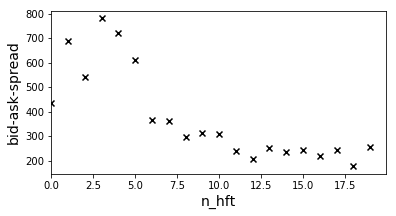

In [54]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.scatter(range(len(average_bid_asks)), [np.mean(bid_asks) for bid_asks in average_bid_asks], c='k', marker='x', label='Bid-ask')

#ax1.legend(frameon=True, loc='best', framealpha=0.8)

ax1.set_ylabel('bid-ask-spread', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)
#fig.savefig('auto_correlation.png')

# Volume increases

In [55]:
def vol(orderbooks):
    volume = []
    for ob in orderbooks:
        total_tick_volume = [sum(volumes) for volumes in ob.transaction_volumes_history]
        volume.append(sum(total_tick_volume))
    return volume

In [56]:
volumes = [vol(orderbooks) for orderbooks in obs]

(0, 19.957096774193548)

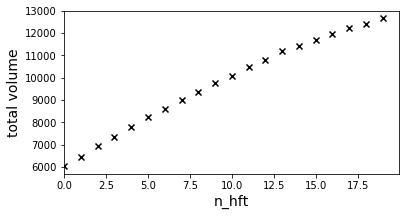

In [57]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.scatter(range(len(volumes)), [np.mean(volume) for volume in volumes], c='k', marker='x')

#ax1.legend(frameon=True, loc='best', framealpha=0.8)

ax1.set_ylabel('total volume', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)

# Volatility decreases

In [58]:
def vola(orderbooks):
    volatility = []
    for ob in orderbooks:
        end_tick_price = ob.tick_close_price #[np.mean(prices) for prices in orderbook.transaction_prices_history]
        returns = pd.Series(np.array(end_tick_price)).pct_change()
        volatility.append(returns.std())
    return volatility

In [59]:
volatilities = [vola(orderbooks) for orderbooks in obs]

(0, 19.957096774193548)

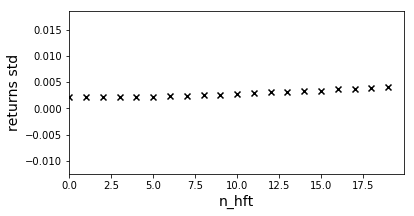

In [60]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.scatter(range(len(volatilities)), [np.mean(volatility) for volatility in volatilities], c='k', marker='x')

ax1.set_ylabel('returns std', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)

# Orderbook depth decreases
Total orderbook depth decreases because HFMs generally take the other side of the orderbook and therefore empty the fuller side of the orderbook.

In [84]:
def depth(orderbooks):
    average_depth = []
    average_imbalance = []
    for ob in orderbooks:
        av_ask_depth = np.mean(ob.tick_bid_depth) #[np.mean(prices) for prices in orderbook.transaction_prices_history]
        av_bid_depth = np.mean(ob.tick_ask_depth)
        average_imbalance.append(np.mean(abs(np.array(ob.tick_bid_depth) - np.array(ob.tick_ask_depth))))
        average_depth.append(av_ask_depth + av_bid_depth)
    return average_depth, average_imbalance

In [85]:
depths = [depth(orderbooks)[0] for orderbooks in obs]
imbalance = [depth(orderbooks)[1] for orderbooks in obs]

(0, 19.957096774193548)

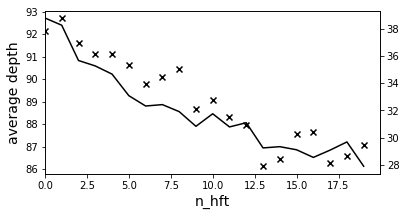

In [90]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.scatter(range(len(depths)), [np.mean(d) for d in depths], c='k', marker='x')

ax2 = ax1.twinx()
ax2.plot(range(len(imbalance)), [np.mean(i) for i in imbalance], c='k')

ax1.set_ylabel('average depth', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)

# Complete picture

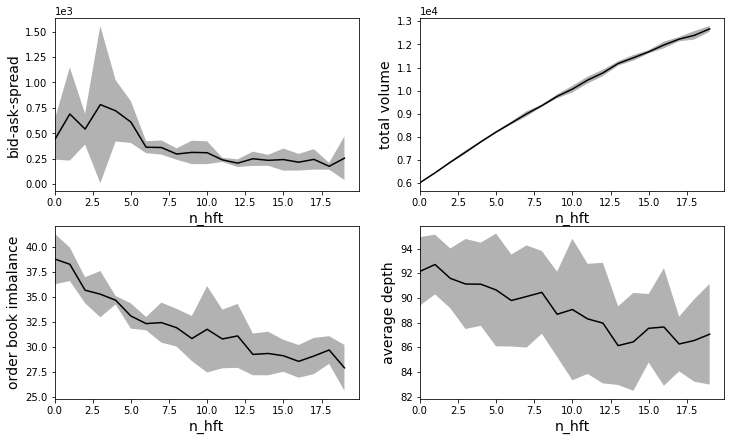

In [93]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,7))

ax1.plot(range(len(average_bid_asks)), [np.mean(bid_asks) for bid_asks in average_bid_asks], c='k', label='Bid-ask')
ax1.fill_between(range(len(average_bid_asks)), 
                 np.array([np.mean(bid_asks) for bid_asks in average_bid_asks])+np.array([np.std(bid_asks) for bid_asks in average_bid_asks]), 
                 np.array([np.mean(bid_asks) for bid_asks in average_bid_asks])-np.array([np.std(bid_asks) for bid_asks in average_bid_asks]), 
                 alpha=0.3, facecolor='black')

ax1.set_ylabel('bid-ask-spread', fontsize='14')
ax1.set_xlabel('n_hft', fontsize='14')
ax1.set_xlim(xmin=0)

ax2.plot(range(len(volumes)), [np.mean(volume) for volume in volumes], c='k')
ax2.fill_between(range(len(volumes)), 
                 np.array([np.mean(volume) for volume in volumes])+np.array([np.std(volume) for volume in volumes]), 
                 np.array([np.mean(volume) for volume in volumes])-np.array([np.std(volume) for volume in volumes]), 
                 alpha=0.3, facecolor='black')

ax2.set_ylabel('total volume', fontsize='14')
ax2.set_xlabel('n_hft', fontsize='14')
ax2.set_xlim(xmin=0)

ax3.plot(range(len(imbalance)), [np.mean(i) for i in imbalance], c='k')
ax3.fill_between(range(len(imbalance)), 
                 np.array([np.mean(i) for i in imbalance])+np.array([np.std(i) for i in imbalance]), 
                 np.array([np.mean(i) for i in imbalance])-np.array([np.std(i) for i in imbalance]), 
                 alpha=0.3, facecolor='black')
ax3.set_ylabel('order book imbalance', fontsize='14')
ax3.set_xlabel('n_hft', fontsize='14')
ax3.set_xlim(xmin=0)

ax4.plot(range(len(depths)), [np.mean(d) for d in depths], c='k')
ax4.fill_between(range(len(depths)), 
                 np.array([np.mean(d) for d in depths])+np.array([np.std(d) for d in depths]), 
                 np.array([np.mean(d) for d in depths])-np.array([np.std(d) for d in depths]), 
                 alpha=0.3, facecolor='black')

ax4.set_ylabel('average depth', fontsize='14')
ax4.set_xlabel('n_hft', fontsize='14')
ax4.set_xlim(xmin=0)

for ax in [ax1, ax2, ax3]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
fig.savefig('predictions.png')